# Scraping News Articles for Data Retrieval

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [14]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
                        
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [15]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Selena Gomez files $10 million lawsuit against...,Singer Selena Gomez is suing the makers of a m...,technology
1,"Facebook to notify users who liked, commented ...",Facebook has announced that it will now be not...,technology
2,"Pichai, Nadella, 4 other Indian-Americans on T...",US President Donald Trump has named six Indian...,technology
3,Trump halting WHO funding doesn't make any sen...,Philanthropist Melinda Gates has said that US ...,technology
4,Amazon employees ask workers to call in sick t...,A group of Amazon employees has called for wor...,technology
5,We will significantly slow pace of hiring in 2...,Google and Alphabet CEO Sundar Pichai has emai...,technology
6,Apple CEO Tim Cook admits potential job cuts a...,"In a virtual meeting with employees, Apple CEO...",technology
7,Extremely serious about users' security: Zoom ...,Responding to the government calling it unsafe...,technology
8,"One was shirtless, one in bed: US judge on law...","A judge in Florida, US named Dennis Bailey has...",technology
9,Twitter's billionaire CEO takes salary of $1.4...,Twitter's billionaire CEO Jack Dorsey declined...,technology


In [16]:
news_df.news_category.value_counts()

technology    25
sports        24
world         24
Name: news_category, dtype: int64

# Text Wrangling & Pre-processing

In [46]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

In [48]:
nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Removing HTML tags

In [31]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Removing accented characters

In [32]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expanding Contractions

In [33]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

## Removing Special Characters 

In [34]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Stemming 

In [39]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Lemmatization 

In [49]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

## Removing Stopwords 

In [50]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Bringing it all together — Building a Text Normalizer

In [51]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [52]:
#combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': 'Facebook to notify users who liked, commented on COVID-19 misinformation. Facebook has announced that it will now be notifying users who have interacted with posts that contain "harmful" coronavirus misinformation. Users who have liked, reacted or commented on COVID-19  misinformation will be shown messages in their news feed saying the post has been removed by Facebook. The messages will also connect users to COVID-19 myths debunked by the WHO.',
 'clean_text': 'facebook notify user like comment covid misinformation facebook announce notify user interact post contain harmful coronavirus misinformation user like react comment covid misinformation show message news feed say post remove facebook message also connect user covid myth debunk'}

In [53]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Understanding Language Syntax and Structure

## Tagging Parts of Speech 

In [59]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hp/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [62]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
print(pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']))

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
print(pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag']))

              Word POS tag Tag type
0         Facebook     NNP    PROPN
1               to      TO     PART
2           notify      VB     VERB
3            users     NNS     NOUN
4              who      WP     PRON
5            liked     VBD     VERB
6                ,       ,    PUNCT
7        commented     VBD     VERB
8               on      IN      ADP
9         COVID-19     NNP    PROPN
10  misinformation      NN     NOUN
             Word POS tag
0        Facebook      NN
1              to      TO
2          notify      VB
3           users     NNS
4             who      WP
5          liked,     VBP
6       commented     VBN
7              on      IN
8        COVID-19     NNP
9  misinformation      NN


## Shallow Parsing or Chunking 

In [64]:
import nltk
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to /home/hp/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In [65]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [66]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [68]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(tag, chunk_tag) for (word, tag, chunk_tag) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [73]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [74]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Facebook/NN)
  (VP to/TO notify/VB)
  (NP users/NNS)
  (NP who/WP)
  (VP liked,/VBP commented/VBN)
  (PP on/IN)
  (NP COVID-19/NNP misinformation/NN))


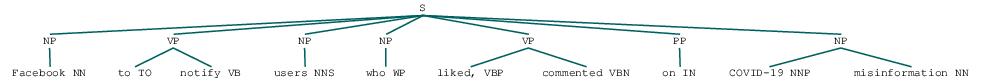

In [76]:
from IPython.display import display
display(chunk_tree)

## Dependency Parsing

In [86]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Facebook[nsubj]--->[]
--------
[]<---to[aux]--->[]
--------
['Facebook', 'to']<---notify[ROOT]--->['users', 'commented']
--------
[]<---users[dobj]--->['liked']
--------
[]<---who[nsubj]--->[]
--------
['who']<---liked[relcl]--->[]
--------
[]<---,[punct]--->[]
--------
[',']<---commented[conj]--->['on']
--------
[]<---on[prep]--->['misinformation']
--------
[]<---COVID-19[nummod]--->[]
--------
['COVID-19']<---misinformation[pobj]--->[]
--------


In [87]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

## Named Entity Recognition 

In [89]:
sentence = str(news_df.iloc[0].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Selena, 'ORG'), (Gomez, 'ORG'), ($, 'MONEY'), (10, 'MONEY'), (million, 'MONEY'), (Selena, 'PERSON'), (Gomez, 'PERSON'), ($, 'MONEY'), (10, 'MONEY'), (million, 'MONEY'), (Gomez, 'ORG'), (millions, 'MONEY'), (of, 'MONEY'), (dollars, 'MONEY'), (800,000, 'MONEY')]


In [90]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [92]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,first,Apple,Tesla,Facebook,MWC,China,one,Thursday,Australia,Amazon,Nathan Lyon,Pakistan,France
Entity Type,GPE,GPE,ORDINAL,ORG,ORG,ORG,ORG,GPE,CARDINAL,DATE,GPE,ORG,PERSON,GPE,GPE
Frequency,28,12,9,8,8,8,8,8,7,6,6,6,5,5,4


In [93]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,DATE,CARDINAL,NORP,ORDINAL,EVENT,MONEY,PERCENT,LOC,PRODUCT,TIME,FAC,QUANTITY
Frequency,150,150,116,75,61,17,15,13,12,7,7,6,2,2,2


# Emotion and Sentiment Analysis

## Sentiment Analysis with AFINN Lexicon 

In [102]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                
                        count      mean       std   min   25%  50%  75%   max
news_category                                                                
sports                   24.0  1.583333  4.915960  -7.0 -1.25  1.5  5.0  12.0
technology               25.0 -0.920000  5.656265 -16.0 -4.00 -1.0  2.0   9.0
world                    24.0 -2.583333  4.844689 -16.0 -4.00 -2.0  0.0   5.0

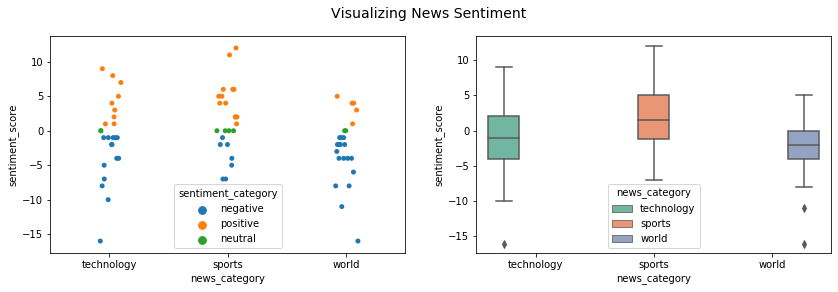

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='sentiment_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

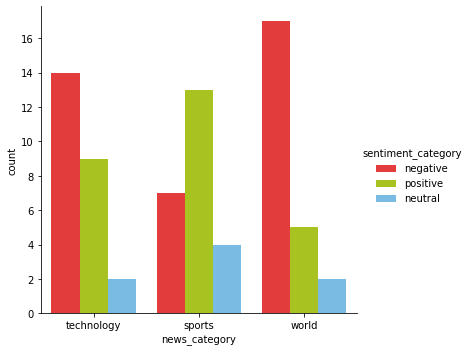

In [114]:
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})


In [120]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 9)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -16)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: A group of Amazon employees has called for workers to take a "sick day" on April 24 to virtually protest its handling of internal criticism. Recently, Amazon fired two employees who criticised its climate policy and the working conditions for warehouse workers amid the coronavirus outbreak. The group said Amazon should disclose its protocol for tracking and reporting COVID-19 cases.

Most Positive Tech News Article: A team of MIT researchers is developing a wearable glove-like device that can "hack" and influence dreams. When "Dormio" senses the users slipping into hypnagogia, the semi-lucid state between wakefulness and sleep, it plays a prerecorded audio cue, typically comprising one word. In a 50-person experiment, researchers found that the content of the audio successfully showed up in people's dreams.


## Sentiment Analysis with TextBlob 

In [122]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                             \
                        count      mean       std    min      25%    50%   
news_category                                                              
sports                   24.0  0.110333  0.179481 -0.215  0.02025  0.061   
technology               25.0 -0.059120  0.235343 -0.800 -0.13000 -0.050   
world                    24.0  0.020333  0.240958 -0.500 -0.11325  0.002   

                              
                   75%   max  
news_category                 
sports         0.23250  0.50  
technology     0.05000  0.39  
world          0.07825  0.75

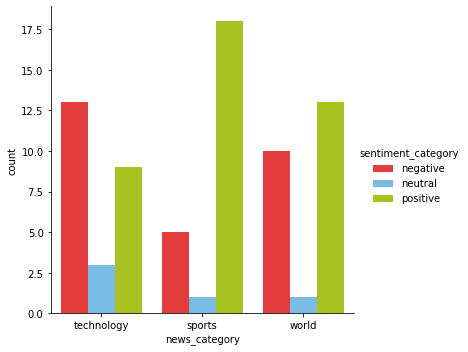

In [123]:
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [124]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.75)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.5)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: The World Health Organization's European office on Thursday said that despite some "optimistic signs" in some of the countries worst hit by the coronavirus, the number of cases was rising and approaching one million in the continent alone. "We remain in the eye of the storm," WHO Regional Director for Europe Hans Kluge said.

Most Positive World News Article: The WHO and India's Health Ministry have initiated a systematic engagement of the organisation's polio surveillance network for coronavirus response, WHO chief Tedros Adhanom Ghebreyesus said. They'll be tapping into "best practices and resources that helped India win its war against polio", he added. The WHO field staff will continue to support immunisation and elimination of other diseases.


In [129]:
import model_evaluation_utils as meu
meu.display_confusion_matrix(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

                 Predicted:                 
                   negative neutral positive
Actual: negative         15       4       19
        neutral           6       0        2
        positive          7       1       19
